In [8]:
# student Id : 28280016
# Name: Zhiyue Li
# Email : zlii0010@student.monash.edu

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
import multiprocessing
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
from IPython.display import clear_output
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torchvision.transforms as transforms
import sys



## Dataloader

the following class reads the data for the third assignment and creates a torch dataset object for it. With this, you can easily use a dataloader to train your model. 

Due to size limit on moodle, the data for this assignment should be obtained from 

https://drive.google.com/file/d/1Nj8HK180dVj-Y9b2w2hRGz726c8OTF_C/view?usp=sharing


Make sure that the file "hw3.npz" is located properly (in this example, it should be in the same folder as this notebook.

 



In [9]:
class STLData(Dataset):
    def __init__(self,trn_val_tst = 0, transform=None):
        data = np.load('hw3.npz')
        if trn_val_tst == 0:
            #trainloader
            self.images = data['arr_0']
            self.labels = data['arr_1']
        elif trn_val_tst == 1:
            #valloader
            self.images = data['arr_2']
            self.labels = data['arr_3']
        else:
            #testloader
            self.images = data['arr_4']
            self.labels = data['arr_5']
            
        self.images = np.float32(self.images)/1.0
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
   
        sample = self.images[idx,:]
        labels = self.labels[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample, labels

Here is an example of how you can create a dataloader. 
First read the data. Note that the STL10 class can work with torchvision.transforms that are required in HW3

In [10]:

#Create the training, Validation and Evaluation/Test Datasets
#It is best practice to separate your data into these three Datasets
#Though depending on your task you may only need Training + Evaluation/Test or maybe only a Training set
#(It also depends on how much data you have)
#https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader
train_set = STLData(trn_val_tst=0, transform=torchvision.transforms.ToTensor()) 
val_set = STLData(trn_val_tst=1, transform=torchvision.transforms.ToTensor()) 
test_set = STLData(trn_val_tst=2, transform=torchvision.transforms.ToTensor()) 



Now for a batchsize of 100, you can have a dataloader as follows for your training data. 

In [11]:
batch_size = 100 
n_workers = multiprocessing.cpu_count()
n_workers = 0
trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                          shuffle=True, num_workers=n_workers)
testloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                          shuffle=True, num_workers=n_workers)
valloader = torch.utils.data.DataLoader(val_set, batch_size=batch_size,
                                          shuffle=True, num_workers=n_workers)

Let's visualize some of the images

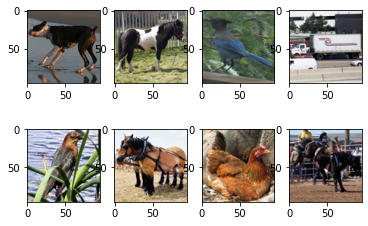

In [12]:
image_batch, labels = next(iter(trainloader))
for tmpC1 in range(8):    
    img = np.moveaxis(image_batch[tmpC1].numpy(),0,2)
    plt.subplot(2,4,tmpC1+1)
    plt.imshow(img/255.0)

In [13]:
# Set device to GPU_index if GPU is available 
GPU_index = 0
device = torch.device(GPU_index if torch.cuda.is_available() else 'cpu')

n_epochs = 30
learning_rate = 1e-3

training_loss_logger = []
training_acc_logger =[]

validation_loss_logger = []
validation_acc_logger = []

test_loss_logger = []
test_acc_logger = []

def calculate_accuracy(fx, y):
    preds = fx.max(1, keepdim=True)[1]
    correct = preds.eq(y.view_as(preds)).sum()
    acc = correct.float()/preds.shape[0]
    return acc


class Model(nn.Module):
    def __init__(self):

        super(Model, self).__init__()
        
        self.conv1 = nn.Conv2d(3,96, kernel_size=7, stride=2, padding=0)
        self.conv2 = nn.Conv2d(96, 64, kernel_size=5, stride=2, padding=0)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=0)
        
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=3, padding=0)
        
        self.linear1 = nn.Linear(1152, 128)
        self.linear2 = nn.Linear(128, 10)
        
        
            
    def forward(self, x):
        print(sys.getsizeof(x))
        out1 = F.relu(self.conv1(x))
        print(sys.getsizeof(out1))

        out2 = F.relu(self.conv2(out1))
        print(sys.getsizeof(out2))

        out3 = F.relu(self.conv3(out2))
        print(sys.getsizeof(out3))

        out4 = self.maxpool(out3)
        out4 = out4.view(out4.shape[0],-1)
        out5 = F.relu(self.linear1(out4))
        out6 = self.linear2(out5)
        
        return out6
      

#This function should perform a single training epoch using our training data
def train(net, device, loader, optimizer, Loss_fun, loss_logger,acc_logger):
    
    #initialise counters
    epoch_loss = 0
    epoch_acc = 0
    
    #Set Network in train mode
    net.train()
    
    for i, (x, y) in enumerate(loader):
        
        #load images and labels to device
        x = x.to(device) # x is the image
        y = y.type(torch.LongTensor).to(device) # y is the corresponding label
                
        #Forward pass of image through network and get output
        fx = net(x)
        
        #Calculate loss using loss function
        loss = Loss_fun(fx, y)
        
        #calculate the accuracy
        acc = calculate_accuracy(fx, y)

        #Zero Gradents
        optimizer.zero_grad()
        #Backpropagate Gradents
        loss.backward()
        #Do a single optimization step
        optimizer.step()
        
        #create the cumulative sum of the loss and acc
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        #log the loss for plotting
        loss_logger.append(loss.item())
        acc_logger.append(acc.item())
        

        #clear_output is a handy function from the IPython.display module
        #it simply clears the output of the running cell
        
        #clear_output(True)
        print("TRAINING: | Itteration [%d/%d] | Loss %.2f |" %(i+1 ,len(loader) , loss.item()))
        
    #return the avaerage loss and acc from the epoch as well as the logger array       
    return epoch_loss / len(loader), epoch_acc / len(loader), loss_logger,acc_logger

#This function should perform a single evaluation epoch and will be passed our validation or evaluation/test data
#it WILL NOT be used to train out model
def evaluate(net, device, loader, Loss_fun, loss_logger = None,acc_logger= None):
    
    epoch_loss = 0
    epoch_acc = 0
    
    #Set network in evaluation mode
    #Layers like Dropout will be disabled
    #Layers like Batchnorm will stop calculating running mean and standard deviation
    #and use current stored values
    net.eval()
    
    with torch.no_grad():
        for i, (x, y) in enumerate(loader):
            
            #load images and labels to device
            x = x.to(device)
            y = y.type(torch.LongTensor).to(device) # y is the corresponding label
            
            #Forward pass of image through network
            fx = net(x)
            
            #Calculate loss using loss function
            loss = Loss_fun(fx, y)
            
            #calculate the accuracy
            acc = calculate_accuracy(fx, y)
            
            #log the cumulative sum of the loss and acc
            epoch_loss += loss.item()
            epoch_acc += acc.item()
            
            #log the loss for plotting if we passed a logger to the function
            if not (loss_logger is None):
                loss_logger.append(loss.item())
            
            if not (acc_logger is None):
                acc_logger.append(acc.item())
                
            #clear_output(True)
            print("EVALUATION: | Itteration [%d/%d] | Loss %.2f | Accuracy %.2f%% |" %(i+1 ,len(loader), loss.item(), 100*(epoch_acc/ len(loader))))
    
    #return the avaerage loss and acc from the epoch as well as the logger array       
    return epoch_loss / len(loader), epoch_acc / len(loader), loss_logger,acc_logger

# Transfer for model to GPU
net = Model().to(device)
# Use the Adam optimiser to update the weights of the model
optimizer = optim.Adam(net.parameters(), lr = learning_rate)
#Cross entropy -- softmax over the class and negative log likelihood loss
loss_fn = nn.CrossEntropyLoss()


0
72
72
72
72
TRAINING: | Itteration [1/80] | Loss 3.58 |
72
72
72
72
TRAINING: | Itteration [2/80] | Loss 11.15 |
72
72
72
72
TRAINING: | Itteration [3/80] | Loss 4.00 |
72
72
72
72
TRAINING: | Itteration [4/80] | Loss 3.22 |
72
72
72
72
TRAINING: | Itteration [5/80] | Loss 2.58 |
72
72
72
72
TRAINING: | Itteration [6/80] | Loss 2.32 |
72
72
72
72
TRAINING: | Itteration [7/80] | Loss 2.42 |
72
72
72
72
TRAINING: | Itteration [8/80] | Loss 2.33 |
72
72
72
72
TRAINING: | Itteration [9/80] | Loss 2.30 |
72
72
72
72
TRAINING: | Itteration [10/80] | Loss 2.30 |
72
72
72
72
TRAINING: | Itteration [11/80] | Loss 2.29 |
72
72
72
72
TRAINING: | Itteration [12/80] | Loss 2.31 |
72
72
72
72
TRAINING: | Itteration [13/80] | Loss 2.28 |
72
72
72
72
TRAINING: | Itteration [14/80] | Loss 2.30 |
72
72
72
72
TRAINING: | Itteration [15/80] | Loss 2.30 |
72
72
72
72
TRAINING: | Itteration [16/80] | Loss 2.30 |
72
72
72
72
TRAINING: | Itteration [17/80] | Loss 2.27 |
72
72
72
72
TRAINING: | Itteration [1

72
72
72
72
EVALUATION: | Itteration [30/30] | Loss 1.59 | Accuracy 37.43% |
Saving Model
| Epoch: 01 | Train Loss: 2.155 | Train Acc: 25.59% | Val. Loss: 1.679 | Val. Acc: 38.05% |
1
72
72
72
72
TRAINING: | Itteration [1/80] | Loss 1.55 |
72
72
72
72
TRAINING: | Itteration [2/80] | Loss 1.68 |
72
72
72
72
TRAINING: | Itteration [3/80] | Loss 1.76 |
72
72
72
72
TRAINING: | Itteration [4/80] | Loss 1.70 |
72
72
72
72
TRAINING: | Itteration [5/80] | Loss 1.56 |
72
72
72
72
TRAINING: | Itteration [6/80] | Loss 1.58 |
72
72
72
72
TRAINING: | Itteration [7/80] | Loss 1.70 |
72
72
72
72
TRAINING: | Itteration [8/80] | Loss 1.61 |
72
72
72
72
TRAINING: | Itteration [9/80] | Loss 1.46 |
72
72
72
72
TRAINING: | Itteration [10/80] | Loss 1.59 |
72
72
72
72
TRAINING: | Itteration [11/80] | Loss 1.47 |
72
72
72
72
TRAINING: | Itteration [12/80] | Loss 1.55 |
72
72
72
72
TRAINING: | Itteration [13/80] | Loss 1.50 |
72
72
72
72
TRAINING: | Itteration [14/80] | Loss 1.45 |
72
72
72
72
TRAINING: | Itt

72
72
72
EVALUATION: | Itteration [29/30] | Loss 1.64 | Accuracy 42.03% |
72
72
72
72
EVALUATION: | Itteration [30/30] | Loss 1.60 | Accuracy 43.40% |
Saving Model
| Epoch: 02 | Train Loss: 1.536 | Train Acc: 42.82% | Val. Loss: 1.501 | Val. Acc: 43.40% |
2
72
72
72
72
TRAINING: | Itteration [1/80] | Loss 1.40 |
72
72
72
72
TRAINING: | Itteration [2/80] | Loss 1.44 |
72
72
72
72
TRAINING: | Itteration [3/80] | Loss 1.35 |
72
72
72
72
TRAINING: | Itteration [4/80] | Loss 1.34 |
72
72
72
72
TRAINING: | Itteration [5/80] | Loss 1.30 |
72
72
72
72
TRAINING: | Itteration [6/80] | Loss 1.18 |
72
72
72
72
TRAINING: | Itteration [7/80] | Loss 1.21 |
72
72
72
72
TRAINING: | Itteration [8/80] | Loss 1.37 |
72
72
72
72
TRAINING: | Itteration [9/80] | Loss 1.31 |
72
72
72
72
TRAINING: | Itteration [10/80] | Loss 1.35 |
72
72
72
72
TRAINING: | Itteration [11/80] | Loss 1.35 |
72
72
72
72
TRAINING: | Itteration [12/80] | Loss 1.27 |
72
72
72
72
TRAINING: | Itteration [13/80] | Loss 1.33 |
72
72
72
7

72
72
72
72
EVALUATION: | Itteration [26/30] | Loss 1.50 | Accuracy 42.53% |
72
72
72
72
EVALUATION: | Itteration [27/30] | Loss 1.43 | Accuracy 44.30% |
72
72
72
72
EVALUATION: | Itteration [28/30] | Loss 1.38 | Accuracy 45.90% |
72
72
72
72
EVALUATION: | Itteration [29/30] | Loss 1.68 | Accuracy 47.23% |
72
72
72
72
EVALUATION: | Itteration [30/30] | Loss 1.46 | Accuracy 48.73% |
Saving Model
| Epoch: 03 | Train Loss: 1.371 | Train Acc: 49.50% | Val. Loss: 1.434 | Val. Acc: 46.50% |
3
72
72
72
72
TRAINING: | Itteration [1/80] | Loss 1.09 |
72
72
72
72
TRAINING: | Itteration [2/80] | Loss 1.31 |
72
72
72
72
TRAINING: | Itteration [3/80] | Loss 1.30 |
72
72
72
72
TRAINING: | Itteration [4/80] | Loss 1.12 |
72
72
72
72
TRAINING: | Itteration [5/80] | Loss 1.22 |
72
72
72
72
TRAINING: | Itteration [6/80] | Loss 1.22 |
72
72
72
72
TRAINING: | Itteration [7/80] | Loss 1.15 |
72
72
72
72
TRAINING: | Itteration [8/80] | Loss 1.22 |
72
72
72
72
TRAINING: | Itteration [9/80] | Loss 1.32 |
72
7

72
72
72
EVALUATION: | Itteration [25/30] | Loss 1.46 | Accuracy 44.03% |
72
72
72
72
EVALUATION: | Itteration [26/30] | Loss 1.24 | Accuracy 45.73% |
72
72
72
72
EVALUATION: | Itteration [27/30] | Loss 1.39 | Accuracy 47.27% |
72
72
72
72
EVALUATION: | Itteration [28/30] | Loss 1.38 | Accuracy 48.57% |
72
72
72
72
EVALUATION: | Itteration [29/30] | Loss 1.29 | Accuracy 50.30% |
72
72
72
72
EVALUATION: | Itteration [30/30] | Loss 1.33 | Accuracy 52.10% |
Saving Model
| Epoch: 04 | Train Loss: 1.228 | Train Acc: 54.27% | Val. Loss: 1.386 | Val. Acc: 50.60% |
4
72
72
72
72
TRAINING: | Itteration [1/80] | Loss 1.07 |
72
72
72
72
TRAINING: | Itteration [2/80] | Loss 1.05 |
72
72
72
72
TRAINING: | Itteration [3/80] | Loss 1.10 |
72
72
72
72
TRAINING: | Itteration [4/80] | Loss 0.95 |
72
72
72
72
TRAINING: | Itteration [5/80] | Loss 1.03 |
72
72
72
72
TRAINING: | Itteration [6/80] | Loss 1.20 |
72
72
72
72
TRAINING: | Itteration [7/80] | Loss 1.10 |
72
72
72
72
TRAINING: | Itteration [8/80] 

72
72
72
72
EVALUATION: | Itteration [22/30] | Loss 1.40 | Accuracy 37.43% |
72
72
72
72
EVALUATION: | Itteration [23/30] | Loss 1.43 | Accuracy 39.30% |
72
72
72
72
EVALUATION: | Itteration [24/30] | Loss 1.25 | Accuracy 41.07% |
72
72
72
72
EVALUATION: | Itteration [25/30] | Loss 1.38 | Accuracy 42.90% |
72
72
72
72
EVALUATION: | Itteration [26/30] | Loss 1.10 | Accuracy 44.87% |
72
72
72
72
EVALUATION: | Itteration [27/30] | Loss 1.37 | Accuracy 46.63% |
72
72
72
72
EVALUATION: | Itteration [28/30] | Loss 1.61 | Accuracy 48.33% |
72
72
72
72
EVALUATION: | Itteration [29/30] | Loss 1.34 | Accuracy 50.07% |
72
72
72
72
EVALUATION: | Itteration [30/30] | Loss 1.44 | Accuracy 51.73% |
Saving Model
| Epoch: 05 | Train Loss: 1.114 | Train Acc: 59.77% | Val. Loss: 1.442 | Val. Acc: 50.60% |
5
72
72
72
72
TRAINING: | Itteration [1/80] | Loss 0.94 |
72
72
72
72
TRAINING: | Itteration [2/80] | Loss 1.05 |
72
72
72
72
TRAINING: | Itteration [3/80] | Loss 1.05 |
72
72
72
72
TRAINING: | Itterati

72
72
72
72
EVALUATION: | Itteration [21/30] | Loss 1.37 | Accuracy 35.10% |
72
72
72
72
EVALUATION: | Itteration [22/30] | Loss 1.54 | Accuracy 36.70% |
72
72
72
72
EVALUATION: | Itteration [23/30] | Loss 1.35 | Accuracy 38.50% |
72
72
72
72
EVALUATION: | Itteration [24/30] | Loss 1.25 | Accuracy 40.33% |
72
72
72
72
EVALUATION: | Itteration [25/30] | Loss 1.51 | Accuracy 41.90% |
72
72
72
72
EVALUATION: | Itteration [26/30] | Loss 1.43 | Accuracy 43.50% |
72
72
72
72
EVALUATION: | Itteration [27/30] | Loss 1.54 | Accuracy 45.07% |
72
72
72
72
EVALUATION: | Itteration [28/30] | Loss 1.30 | Accuracy 46.70% |
72
72
72
72
EVALUATION: | Itteration [29/30] | Loss 1.48 | Accuracy 48.40% |
72
72
72
72
EVALUATION: | Itteration [30/30] | Loss 1.22 | Accuracy 50.43% |
Saving Model
| Epoch: 06 | Train Loss: 1.015 | Train Acc: 63.00% | Val. Loss: 1.469 | Val. Acc: 49.45% |
6
72
72
72
72
TRAINING: | Itteration [1/80] | Loss 0.85 |
72
72
72
72
TRAINING: | Itteration [2/80] | Loss 0.90 |
72
72
72
72

72
72
72
72
EVALUATION: | Itteration [18/30] | Loss 1.29 | Accuracy 32.37% |
72
72
72
72
EVALUATION: | Itteration [19/30] | Loss 1.62 | Accuracy 33.97% |
72
72
72
72
EVALUATION: | Itteration [20/30] | Loss 1.54 | Accuracy 35.67% |
72
72
72
72
EVALUATION: | Itteration [21/30] | Loss 1.42 | Accuracy 37.37% |
72
72
72
72
EVALUATION: | Itteration [22/30] | Loss 1.19 | Accuracy 39.33% |
72
72
72
72
EVALUATION: | Itteration [23/30] | Loss 1.39 | Accuracy 41.03% |
72
72
72
72
EVALUATION: | Itteration [24/30] | Loss 1.36 | Accuracy 42.83% |
72
72
72
72
EVALUATION: | Itteration [25/30] | Loss 1.69 | Accuracy 44.20% |
72
72
72
72
EVALUATION: | Itteration [26/30] | Loss 1.33 | Accuracy 45.87% |
72
72
72
72
EVALUATION: | Itteration [27/30] | Loss 1.66 | Accuracy 47.67% |
72
72
72
72
EVALUATION: | Itteration [28/30] | Loss 1.32 | Accuracy 49.40% |
72
72
72
72
EVALUATION: | Itteration [29/30] | Loss 1.22 | Accuracy 51.43% |
72
72
72
72
EVALUATION: | Itteration [30/30] | Loss 1.18 | Accuracy 53.33% |

72
72
72
EVALUATION: | Itteration [15/30] | Loss 1.51 | Accuracy 26.60% |
72
72
72
72
EVALUATION: | Itteration [16/30] | Loss 1.37 | Accuracy 28.53% |
72
72
72
72
EVALUATION: | Itteration [17/30] | Loss 1.55 | Accuracy 30.23% |
72
72
72
72
EVALUATION: | Itteration [18/30] | Loss 1.50 | Accuracy 31.87% |
72
72
72
72
EVALUATION: | Itteration [19/30] | Loss 1.37 | Accuracy 33.67% |
72
72
72
72
EVALUATION: | Itteration [20/30] | Loss 1.41 | Accuracy 35.47% |
72
72
72
72
EVALUATION: | Itteration [21/30] | Loss 1.35 | Accuracy 37.37% |
72
72
72
72
EVALUATION: | Itteration [22/30] | Loss 1.35 | Accuracy 39.37% |
72
72
72
72
EVALUATION: | Itteration [23/30] | Loss 1.13 | Accuracy 41.27% |
72
72
72
72
EVALUATION: | Itteration [24/30] | Loss 1.81 | Accuracy 42.87% |
72
72
72
72
EVALUATION: | Itteration [25/30] | Loss 1.64 | Accuracy 44.60% |
72
72
72
72
EVALUATION: | Itteration [26/30] | Loss 1.77 | Accuracy 46.10% |
72
72
72
72
EVALUATION: | Itteration [27/30] | Loss 1.39 | Accuracy 47.93% |
72

72
72
72
72
EVALUATION: | Itteration [14/30] | Loss 1.63 | Accuracy 23.23% |
72
72
72
72
EVALUATION: | Itteration [15/30] | Loss 1.82 | Accuracy 24.87% |
72
72
72
72
EVALUATION: | Itteration [16/30] | Loss 1.52 | Accuracy 26.43% |
72
72
72
72
EVALUATION: | Itteration [17/30] | Loss 1.67 | Accuracy 28.33% |
72
72
72
72
EVALUATION: | Itteration [18/30] | Loss 1.71 | Accuracy 30.17% |
72
72
72
72
EVALUATION: | Itteration [19/30] | Loss 1.64 | Accuracy 31.57% |
72
72
72
72
EVALUATION: | Itteration [20/30] | Loss 1.67 | Accuracy 33.33% |
72
72
72
72
EVALUATION: | Itteration [21/30] | Loss 1.84 | Accuracy 34.97% |
72
72
72
72
EVALUATION: | Itteration [22/30] | Loss 1.49 | Accuracy 36.77% |
72
72
72
72
EVALUATION: | Itteration [23/30] | Loss 1.57 | Accuracy 38.43% |
72
72
72
72
EVALUATION: | Itteration [24/30] | Loss 1.80 | Accuracy 39.93% |
72
72
72
72
EVALUATION: | Itteration [25/30] | Loss 1.35 | Accuracy 41.77% |
72
72
72
72
EVALUATION: | Itteration [26/30] | Loss 1.42 | Accuracy 43.60% |

72
72
72
EVALUATION: | Itteration [13/30] | Loss 1.98 | Accuracy 21.93% |
72
72
72
72
EVALUATION: | Itteration [14/30] | Loss 1.72 | Accuracy 23.63% |
72
72
72
72
EVALUATION: | Itteration [15/30] | Loss 1.22 | Accuracy 25.60% |
72
72
72
72
EVALUATION: | Itteration [16/30] | Loss 1.52 | Accuracy 27.43% |
72
72
72
72
EVALUATION: | Itteration [17/30] | Loss 1.61 | Accuracy 29.20% |
72
72
72
72
EVALUATION: | Itteration [18/30] | Loss 1.28 | Accuracy 31.10% |
72
72
72
72
EVALUATION: | Itteration [19/30] | Loss 1.73 | Accuracy 32.80% |
72
72
72
72
EVALUATION: | Itteration [20/30] | Loss 1.31 | Accuracy 34.83% |
72
72
72
72
EVALUATION: | Itteration [21/30] | Loss 2.17 | Accuracy 36.33% |
72
72
72
72
EVALUATION: | Itteration [22/30] | Loss 1.40 | Accuracy 38.47% |
72
72
72
72
EVALUATION: | Itteration [23/30] | Loss 1.74 | Accuracy 40.00% |
72
72
72
72
EVALUATION: | Itteration [24/30] | Loss 1.53 | Accuracy 41.80% |
72
72
72
72
EVALUATION: | Itteration [25/30] | Loss 1.22 | Accuracy 43.93% |
72

72
72
72
EVALUATION: | Itteration [12/30] | Loss 1.77 | Accuracy 20.57% |
72
72
72
72
EVALUATION: | Itteration [13/30] | Loss 1.69 | Accuracy 22.27% |
72
72
72
72
EVALUATION: | Itteration [14/30] | Loss 1.74 | Accuracy 24.00% |
72
72
72
72
EVALUATION: | Itteration [15/30] | Loss 1.65 | Accuracy 25.77% |
72
72
72
72
EVALUATION: | Itteration [16/30] | Loss 1.72 | Accuracy 27.33% |
72
72
72
72
EVALUATION: | Itteration [17/30] | Loss 1.95 | Accuracy 28.97% |
72
72
72
72
EVALUATION: | Itteration [18/30] | Loss 2.20 | Accuracy 30.47% |
72
72
72
72
EVALUATION: | Itteration [19/30] | Loss 1.88 | Accuracy 32.30% |
72
72
72
72
EVALUATION: | Itteration [20/30] | Loss 2.06 | Accuracy 33.97% |
72
72
72
72
EVALUATION: | Itteration [21/30] | Loss 1.92 | Accuracy 35.50% |
72
72
72
72
EVALUATION: | Itteration [22/30] | Loss 1.64 | Accuracy 37.23% |
72
72
72
72
EVALUATION: | Itteration [23/30] | Loss 1.83 | Accuracy 38.93% |
72
72
72
72
EVALUATION: | Itteration [24/30] | Loss 1.45 | Accuracy 41.07% |
72

72
72
72
EVALUATION: | Itteration [11/30] | Loss 2.14 | Accuracy 18.67% |
72
72
72
72
EVALUATION: | Itteration [12/30] | Loss 1.85 | Accuracy 20.43% |
72
72
72
72
EVALUATION: | Itteration [13/30] | Loss 1.89 | Accuracy 21.93% |
72
72
72
72
EVALUATION: | Itteration [14/30] | Loss 1.87 | Accuracy 23.80% |
72
72
72
72
EVALUATION: | Itteration [15/30] | Loss 1.85 | Accuracy 25.50% |
72
72
72
72
EVALUATION: | Itteration [16/30] | Loss 2.10 | Accuracy 27.07% |
72
72
72
72
EVALUATION: | Itteration [17/30] | Loss 1.51 | Accuracy 28.93% |
72
72
72
72
EVALUATION: | Itteration [18/30] | Loss 2.36 | Accuracy 30.23% |
72
72
72
72
EVALUATION: | Itteration [19/30] | Loss 2.22 | Accuracy 31.90% |
72
72
72
72
EVALUATION: | Itteration [20/30] | Loss 1.91 | Accuracy 33.60% |
72
72
72
72
EVALUATION: | Itteration [21/30] | Loss 1.82 | Accuracy 35.43% |
72
72
72
72
EVALUATION: | Itteration [22/30] | Loss 1.93 | Accuracy 36.97% |
72
72
72
72
EVALUATION: | Itteration [23/30] | Loss 1.88 | Accuracy 38.87% |
72

72
72
72
EVALUATION: | Itteration [8/30] | Loss 1.95 | Accuracy 13.37% |
72
72
72
72
EVALUATION: | Itteration [9/30] | Loss 2.20 | Accuracy 15.00% |
72
72
72
72
EVALUATION: | Itteration [10/30] | Loss 1.98 | Accuracy 16.57% |
72
72
72
72
EVALUATION: | Itteration [11/30] | Loss 1.93 | Accuracy 18.27% |
72
72
72
72
EVALUATION: | Itteration [12/30] | Loss 1.52 | Accuracy 20.27% |
72
72
72
72
EVALUATION: | Itteration [13/30] | Loss 2.22 | Accuracy 21.67% |
72
72
72
72
EVALUATION: | Itteration [14/30] | Loss 2.44 | Accuracy 23.37% |
72
72
72
72
EVALUATION: | Itteration [15/30] | Loss 1.83 | Accuracy 25.10% |
72
72
72
72
EVALUATION: | Itteration [16/30] | Loss 2.18 | Accuracy 26.73% |
72
72
72
72
EVALUATION: | Itteration [17/30] | Loss 2.13 | Accuracy 28.33% |
72
72
72
72
EVALUATION: | Itteration [18/30] | Loss 2.46 | Accuracy 29.90% |
72
72
72
72
EVALUATION: | Itteration [19/30] | Loss 2.25 | Accuracy 31.43% |
72
72
72
72
EVALUATION: | Itteration [20/30] | Loss 2.03 | Accuracy 33.03% |
72
7

72
72
72
72
EVALUATION: | Itteration [5/30] | Loss 2.60 | Accuracy 8.20% |
72
72
72
72
EVALUATION: | Itteration [6/30] | Loss 2.52 | Accuracy 9.90% |
72
72
72
72
EVALUATION: | Itteration [7/30] | Loss 2.29 | Accuracy 11.63% |
72
72
72
72
EVALUATION: | Itteration [8/30] | Loss 2.32 | Accuracy 13.43% |
72
72
72
72
EVALUATION: | Itteration [9/30] | Loss 2.65 | Accuracy 15.07% |
72
72
72
72
EVALUATION: | Itteration [10/30] | Loss 2.59 | Accuracy 16.63% |
72
72
72
72
EVALUATION: | Itteration [11/30] | Loss 2.37 | Accuracy 18.27% |
72
72
72
72
EVALUATION: | Itteration [12/30] | Loss 1.63 | Accuracy 20.20% |
72
72
72
72
EVALUATION: | Itteration [13/30] | Loss 3.05 | Accuracy 21.53% |
72
72
72
72
EVALUATION: | Itteration [14/30] | Loss 2.50 | Accuracy 23.13% |
72
72
72
72
EVALUATION: | Itteration [15/30] | Loss 2.12 | Accuracy 24.77% |
72
72
72
72
EVALUATION: | Itteration [16/30] | Loss 2.43 | Accuracy 26.27% |
72
72
72
72
EVALUATION: | Itteration [17/30] | Loss 2.20 | Accuracy 28.00% |
72
72


72
72
72
72
EVALUATION: | Itteration [2/30] | Loss 2.16 | Accuracy 3.17% |
72
72
72
72
EVALUATION: | Itteration [3/30] | Loss 2.54 | Accuracy 4.67% |
72
72
72
72
EVALUATION: | Itteration [4/30] | Loss 2.59 | Accuracy 6.17% |
72
72
72
72
EVALUATION: | Itteration [5/30] | Loss 2.62 | Accuracy 7.67% |
72
72
72
72
EVALUATION: | Itteration [6/30] | Loss 2.76 | Accuracy 9.00% |
72
72
72
72
EVALUATION: | Itteration [7/30] | Loss 2.34 | Accuracy 10.83% |
72
72
72
72
EVALUATION: | Itteration [8/30] | Loss 2.53 | Accuracy 12.63% |
72
72
72
72
EVALUATION: | Itteration [9/30] | Loss 3.03 | Accuracy 14.47% |
72
72
72
72
EVALUATION: | Itteration [10/30] | Loss 2.20 | Accuracy 16.43% |
72
72
72
72
EVALUATION: | Itteration [11/30] | Loss 2.70 | Accuracy 17.97% |
72
72
72
72
EVALUATION: | Itteration [12/30] | Loss 2.73 | Accuracy 19.63% |
72
72
72
72
EVALUATION: | Itteration [13/30] | Loss 2.53 | Accuracy 21.37% |
72
72
72
72
EVALUATION: | Itteration [14/30] | Loss 1.94 | Accuracy 23.13% |
72
72
72
72


72
72
72
EVALUATION: | Itteration [20/20] | Loss 2.91 | Accuracy 49.20% |
72
72
72
72
EVALUATION: | Itteration [1/30] | Loss 2.23 | Accuracy 1.97% |
72
72
72
72
EVALUATION: | Itteration [2/30] | Loss 2.81 | Accuracy 3.70% |
72
72
72
72
EVALUATION: | Itteration [3/30] | Loss 2.26 | Accuracy 5.37% |
72
72
72
72
EVALUATION: | Itteration [4/30] | Loss 2.82 | Accuracy 7.10% |
72
72
72
72
EVALUATION: | Itteration [5/30] | Loss 2.77 | Accuracy 8.87% |
72
72
72
72
EVALUATION: | Itteration [6/30] | Loss 2.81 | Accuracy 10.57% |
72
72
72
72
EVALUATION: | Itteration [7/30] | Loss 2.76 | Accuracy 12.20% |
72
72
72
72
EVALUATION: | Itteration [8/30] | Loss 3.25 | Accuracy 13.73% |
72
72
72
72
EVALUATION: | Itteration [9/30] | Loss 2.72 | Accuracy 15.43% |
72
72
72
72
EVALUATION: | Itteration [10/30] | Loss 3.08 | Accuracy 16.93% |
72
72
72
72
EVALUATION: | Itteration [11/30] | Loss 2.90 | Accuracy 18.43% |
72
72
72
72
EVALUATION: | Itteration [12/30] | Loss 2.66 | Accuracy 20.17% |
72
72
72
72
EVAL

72
72
72
72
EVALUATION: | Itteration [18/20] | Loss 2.60 | Accuracy 43.90% |
72
72
72
72
EVALUATION: | Itteration [19/20] | Loss 3.46 | Accuracy 46.30% |
72
72
72
72
EVALUATION: | Itteration [20/20] | Loss 4.06 | Accuracy 48.50% |
72
72
72
72
EVALUATION: | Itteration [1/30] | Loss 3.33 | Accuracy 1.30% |
72
72
72
72
EVALUATION: | Itteration [2/30] | Loss 3.17 | Accuracy 3.00% |
72
72
72
72
EVALUATION: | Itteration [3/30] | Loss 2.94 | Accuracy 4.53% |
72
72
72
72
EVALUATION: | Itteration [4/30] | Loss 2.43 | Accuracy 6.40% |
72
72
72
72
EVALUATION: | Itteration [5/30] | Loss 3.14 | Accuracy 7.90% |
72
72
72
72
EVALUATION: | Itteration [6/30] | Loss 3.87 | Accuracy 9.40% |
72
72
72
72
EVALUATION: | Itteration [7/30] | Loss 3.50 | Accuracy 11.00% |
72
72
72
72
EVALUATION: | Itteration [8/30] | Loss 3.57 | Accuracy 12.40% |
72
72
72
72
EVALUATION: | Itteration [9/30] | Loss 3.42 | Accuracy 13.97% |
72
72
72
72
EVALUATION: | Itteration [10/30] | Loss 2.91 | Accuracy 15.73% |
72
72
72
72
EV

72
72
72
EVALUATION: | Itteration [15/20] | Loss 3.35 | Accuracy 37.30% |
72
72
72
72
EVALUATION: | Itteration [16/20] | Loss 4.65 | Accuracy 39.50% |
72
72
72
72
EVALUATION: | Itteration [17/20] | Loss 3.22 | Accuracy 41.90% |
72
72
72
72
EVALUATION: | Itteration [18/20] | Loss 2.75 | Accuracy 44.85% |
72
72
72
72
EVALUATION: | Itteration [19/20] | Loss 3.51 | Accuracy 47.40% |
72
72
72
72
EVALUATION: | Itteration [20/20] | Loss 2.77 | Accuracy 49.90% |
72
72
72
72
EVALUATION: | Itteration [1/30] | Loss 3.29 | Accuracy 1.70% |
72
72
72
72
EVALUATION: | Itteration [2/30] | Loss 2.97 | Accuracy 3.20% |
72
72
72
72
EVALUATION: | Itteration [3/30] | Loss 2.99 | Accuracy 4.87% |
72
72
72
72
EVALUATION: | Itteration [4/30] | Loss 3.09 | Accuracy 6.43% |
72
72
72
72
EVALUATION: | Itteration [5/30] | Loss 3.02 | Accuracy 8.00% |
72
72
72
72
EVALUATION: | Itteration [6/30] | Loss 3.14 | Accuracy 9.43% |
72
72
72
72
EVALUATION: | Itteration [7/30] | Loss 2.86 | Accuracy 11.17% |
72
72
72
72
EVA

72
72
72
EVALUATION: | Itteration [14/20] | Loss 4.99 | Accuracy 33.00% |
72
72
72
72
EVALUATION: | Itteration [15/20] | Loss 3.69 | Accuracy 35.45% |
72
72
72
72
EVALUATION: | Itteration [16/20] | Loss 3.67 | Accuracy 38.10% |
72
72
72
72
EVALUATION: | Itteration [17/20] | Loss 3.26 | Accuracy 40.80% |
72
72
72
72
EVALUATION: | Itteration [18/20] | Loss 2.82 | Accuracy 43.55% |
72
72
72
72
EVALUATION: | Itteration [19/20] | Loss 3.60 | Accuracy 46.10% |
72
72
72
72
EVALUATION: | Itteration [20/20] | Loss 3.57 | Accuracy 48.95% |
72
72
72
72
EVALUATION: | Itteration [1/30] | Loss 2.73 | Accuracy 2.03% |
72
72
72
72
EVALUATION: | Itteration [2/30] | Loss 3.39 | Accuracy 3.70% |
72
72
72
72
EVALUATION: | Itteration [3/30] | Loss 3.62 | Accuracy 5.53% |
72
72
72
72
EVALUATION: | Itteration [4/30] | Loss 2.72 | Accuracy 7.30% |
72
72
72
72
EVALUATION: | Itteration [5/30] | Loss 3.11 | Accuracy 9.13% |
72
72
72
72
EVALUATION: | Itteration [6/30] | Loss 3.88 | Accuracy 10.67% |
72
72
72
72
E

72
72
72
72
EVALUATION: | Itteration [11/20] | Loss 3.90 | Accuracy 27.65% |
72
72
72
72
EVALUATION: | Itteration [12/20] | Loss 3.56 | Accuracy 30.05% |
72
72
72
72
EVALUATION: | Itteration [13/20] | Loss 3.81 | Accuracy 32.60% |
72
72
72
72
EVALUATION: | Itteration [14/20] | Loss 2.87 | Accuracy 35.15% |
72
72
72
72
EVALUATION: | Itteration [15/20] | Loss 3.69 | Accuracy 37.70% |
72
72
72
72
EVALUATION: | Itteration [16/20] | Loss 3.32 | Accuracy 40.20% |
72
72
72
72
EVALUATION: | Itteration [17/20] | Loss 3.93 | Accuracy 42.55% |
72
72
72
72
EVALUATION: | Itteration [18/20] | Loss 4.51 | Accuracy 44.90% |
72
72
72
72
EVALUATION: | Itteration [19/20] | Loss 3.95 | Accuracy 47.05% |
72
72
72
72
EVALUATION: | Itteration [20/20] | Loss 3.84 | Accuracy 49.70% |
72
72
72
72
EVALUATION: | Itteration [1/30] | Loss 3.50 | Accuracy 1.73% |
72
72
72
72
EVALUATION: | Itteration [2/30] | Loss 2.61 | Accuracy 3.43% |
72
72
72
72
EVALUATION: | Itteration [3/30] | Loss 2.99 | Accuracy 5.23% |
72
72

72
72
72
72
EVALUATION: | Itteration [10/20] | Loss 4.31 | Accuracy 25.75% |
72
72
72
72
EVALUATION: | Itteration [11/20] | Loss 5.00 | Accuracy 28.00% |
72
72
72
72
EVALUATION: | Itteration [12/20] | Loss 3.73 | Accuracy 30.45% |
72
72
72
72
EVALUATION: | Itteration [13/20] | Loss 4.71 | Accuracy 33.15% |
72
72
72
72
EVALUATION: | Itteration [14/20] | Loss 4.06 | Accuracy 35.55% |
72
72
72
72
EVALUATION: | Itteration [15/20] | Loss 4.44 | Accuracy 37.95% |
72
72
72
72
EVALUATION: | Itteration [16/20] | Loss 4.04 | Accuracy 40.05% |
72
72
72
72
EVALUATION: | Itteration [17/20] | Loss 3.62 | Accuracy 42.55% |
72
72
72
72
EVALUATION: | Itteration [18/20] | Loss 4.71 | Accuracy 44.50% |
72
72
72
72
EVALUATION: | Itteration [19/20] | Loss 3.68 | Accuracy 47.15% |
72
72
72
72
EVALUATION: | Itteration [20/20] | Loss 3.89 | Accuracy 49.25% |
72
72
72
72
EVALUATION: | Itteration [1/30] | Loss 2.94 | Accuracy 2.07% |
72
72
72
72
EVALUATION: | Itteration [2/30] | Loss 3.36 | Accuracy 4.03% |
72


72
72
72
72
EVALUATION: | Itteration [8/20] | Loss 4.74 | Accuracy 19.15% |
72
72
72
72
EVALUATION: | Itteration [9/20] | Loss 3.65 | Accuracy 21.50% |
72
72
72
72
EVALUATION: | Itteration [10/20] | Loss 4.29 | Accuracy 23.95% |
72
72
72
72
EVALUATION: | Itteration [11/20] | Loss 3.96 | Accuracy 26.45% |
72
72
72
72
EVALUATION: | Itteration [12/20] | Loss 3.20 | Accuracy 29.15% |
72
72
72
72
EVALUATION: | Itteration [13/20] | Loss 3.79 | Accuracy 31.65% |
72
72
72
72
EVALUATION: | Itteration [14/20] | Loss 3.56 | Accuracy 34.50% |
72
72
72
72
EVALUATION: | Itteration [15/20] | Loss 3.75 | Accuracy 37.05% |
72
72
72
72
EVALUATION: | Itteration [16/20] | Loss 3.95 | Accuracy 39.65% |
72
72
72
72
EVALUATION: | Itteration [17/20] | Loss 4.82 | Accuracy 41.85% |
72
72
72
72
EVALUATION: | Itteration [18/20] | Loss 4.14 | Accuracy 44.25% |
72
72
72
72
EVALUATION: | Itteration [19/20] | Loss 3.72 | Accuracy 47.25% |
72
72
72
72
EVALUATION: | Itteration [20/20] | Loss 3.66 | Accuracy 49.80% |
7

72
72
72
72
EVALUATION: | Itteration [5/20] | Loss 4.30 | Accuracy 13.20% |
72
72
72
72
EVALUATION: | Itteration [6/20] | Loss 5.30 | Accuracy 15.30% |
72
72
72
72
EVALUATION: | Itteration [7/20] | Loss 3.53 | Accuracy 17.65% |
72
72
72
72
EVALUATION: | Itteration [8/20] | Loss 4.16 | Accuracy 20.10% |
72
72
72
72
EVALUATION: | Itteration [9/20] | Loss 4.27 | Accuracy 22.75% |
72
72
72
72
EVALUATION: | Itteration [10/20] | Loss 4.17 | Accuracy 25.25% |
72
72
72
72
EVALUATION: | Itteration [11/20] | Loss 3.59 | Accuracy 27.70% |
72
72
72
72
EVALUATION: | Itteration [12/20] | Loss 5.57 | Accuracy 30.10% |
72
72
72
72
EVALUATION: | Itteration [13/20] | Loss 3.63 | Accuracy 32.65% |
72
72
72
72
EVALUATION: | Itteration [14/20] | Loss 3.72 | Accuracy 35.25% |
72
72
72
72
EVALUATION: | Itteration [15/20] | Loss 4.47 | Accuracy 37.65% |
72
72
72
72
EVALUATION: | Itteration [16/20] | Loss 4.61 | Accuracy 40.10% |
72
72
72
72
EVALUATION: | Itteration [17/20] | Loss 4.10 | Accuracy 42.70% |
72
7

72
72
72
72
EVALUATION: | Itteration [4/20] | Loss 3.86 | Accuracy 9.75% |
72
72
72
72
EVALUATION: | Itteration [5/20] | Loss 4.27 | Accuracy 12.25% |
72
72
72
72
EVALUATION: | Itteration [6/20] | Loss 3.96 | Accuracy 14.60% |
72
72
72
72
EVALUATION: | Itteration [7/20] | Loss 5.28 | Accuracy 16.70% |
72
72
72
72
EVALUATION: | Itteration [8/20] | Loss 4.25 | Accuracy 19.55% |
72
72
72
72
EVALUATION: | Itteration [9/20] | Loss 4.88 | Accuracy 21.60% |
72
72
72
72
EVALUATION: | Itteration [10/20] | Loss 4.06 | Accuracy 24.15% |
72
72
72
72
EVALUATION: | Itteration [11/20] | Loss 3.07 | Accuracy 27.05% |
72
72
72
72
EVALUATION: | Itteration [12/20] | Loss 4.75 | Accuracy 29.30% |
72
72
72
72
EVALUATION: | Itteration [13/20] | Loss 4.02 | Accuracy 32.00% |
72
72
72
72
EVALUATION: | Itteration [14/20] | Loss 3.45 | Accuracy 34.95% |
72
72
72
72
EVALUATION: | Itteration [15/20] | Loss 3.99 | Accuracy 37.20% |
72
72
72
72
EVALUATION: | Itteration [16/20] | Loss 3.68 | Accuracy 39.45% |
72
72


72
72
72
TRAINING: | Itteration [80/80] | Loss 0.22 |
72
72
72
72
EVALUATION: | Itteration [1/20] | Loss 3.86 | Accuracy 2.80% |
72
72
72
72
EVALUATION: | Itteration [2/20] | Loss 4.58 | Accuracy 5.20% |
72
72
72
72
EVALUATION: | Itteration [3/20] | Loss 4.84 | Accuracy 7.50% |
72
72
72
72
EVALUATION: | Itteration [4/20] | Loss 3.99 | Accuracy 10.05% |
72
72
72
72
EVALUATION: | Itteration [5/20] | Loss 5.08 | Accuracy 12.40% |
72
72
72
72
EVALUATION: | Itteration [6/20] | Loss 3.81 | Accuracy 14.60% |
72
72
72
72
EVALUATION: | Itteration [7/20] | Loss 4.27 | Accuracy 16.90% |
72
72
72
72
EVALUATION: | Itteration [8/20] | Loss 3.24 | Accuracy 19.60% |
72
72
72
72
EVALUATION: | Itteration [9/20] | Loss 3.53 | Accuracy 21.95% |
72
72
72
72
EVALUATION: | Itteration [10/20] | Loss 4.42 | Accuracy 24.60% |
72
72
72
72
EVALUATION: | Itteration [11/20] | Loss 4.30 | Accuracy 26.85% |
72
72
72
72
EVALUATION: | Itteration [12/20] | Loss 5.09 | Accuracy 29.35% |
72
72
72
72
EVALUATION: | Itterati

72
72
TRAINING: | Itteration [75/80] | Loss 0.13 |
72
72
72
72
TRAINING: | Itteration [76/80] | Loss 0.11 |
72
72
72
72
TRAINING: | Itteration [77/80] | Loss 0.20 |
72
72
72
72
TRAINING: | Itteration [78/80] | Loss 0.32 |
72
72
72
72
TRAINING: | Itteration [79/80] | Loss 0.06 |
72
72
72
72
TRAINING: | Itteration [80/80] | Loss 0.17 |
72
72
72
72
EVALUATION: | Itteration [1/20] | Loss 4.13 | Accuracy 2.50% |
72
72
72
72
EVALUATION: | Itteration [2/20] | Loss 4.67 | Accuracy 5.30% |
72
72
72
72
EVALUATION: | Itteration [3/20] | Loss 5.01 | Accuracy 7.70% |
72
72
72
72
EVALUATION: | Itteration [4/20] | Loss 4.98 | Accuracy 10.15% |
72
72
72
72
EVALUATION: | Itteration [5/20] | Loss 4.38 | Accuracy 12.50% |
72
72
72
72
EVALUATION: | Itteration [6/20] | Loss 4.44 | Accuracy 15.05% |
72
72
72
72
EVALUATION: | Itteration [7/20] | Loss 3.54 | Accuracy 17.90% |
72
72
72
72
EVALUATION: | Itteration [8/20] | Loss 4.23 | Accuracy 20.55% |
72
72
72
72
EVALUATION: | Itteration [9/20] | Loss 4.60 | A

72
72
72
TRAINING: | Itteration [70/80] | Loss 0.17 |
72
72
72
72
TRAINING: | Itteration [71/80] | Loss 0.25 |
72
72
72
72
TRAINING: | Itteration [72/80] | Loss 0.11 |
72
72
72
72
TRAINING: | Itteration [73/80] | Loss 0.10 |
72
72
72
72
TRAINING: | Itteration [74/80] | Loss 0.03 |
72
72
72
72
TRAINING: | Itteration [75/80] | Loss 0.08 |
72
72
72
72
TRAINING: | Itteration [76/80] | Loss 0.20 |
72
72
72
72
TRAINING: | Itteration [77/80] | Loss 0.08 |
72
72
72
72
TRAINING: | Itteration [78/80] | Loss 0.28 |
72
72
72
72
TRAINING: | Itteration [79/80] | Loss 0.14 |
72
72
72
72
TRAINING: | Itteration [80/80] | Loss 0.21 |
72
72
72
72
EVALUATION: | Itteration [1/20] | Loss 3.52 | Accuracy 2.45% |
72
72
72
72
EVALUATION: | Itteration [2/20] | Loss 3.05 | Accuracy 5.70% |
72
72
72
72
EVALUATION: | Itteration [3/20] | Loss 4.24 | Accuracy 8.50% |
72
72
72
72
EVALUATION: | Itteration [4/20] | Loss 3.83 | Accuracy 11.10% |
72
72
72
72
EVALUATION: | Itteration [5/20] | Loss 5.71 | Accuracy 13.70% |

72
72
72
TRAINING: | Itteration [65/80] | Loss 0.14 |
72
72
72
72
TRAINING: | Itteration [66/80] | Loss 0.15 |
72
72
72
72
TRAINING: | Itteration [67/80] | Loss 0.23 |
72
72
72
72
TRAINING: | Itteration [68/80] | Loss 0.09 |
72
72
72
72
TRAINING: | Itteration [69/80] | Loss 0.12 |
72
72
72
72
TRAINING: | Itteration [70/80] | Loss 0.22 |
72
72
72
72
TRAINING: | Itteration [71/80] | Loss 0.11 |
72
72
72
72
TRAINING: | Itteration [72/80] | Loss 0.12 |
72
72
72
72
TRAINING: | Itteration [73/80] | Loss 0.19 |
72
72
72
72
TRAINING: | Itteration [74/80] | Loss 0.19 |
72
72
72
72
TRAINING: | Itteration [75/80] | Loss 0.14 |
72
72
72
72
TRAINING: | Itteration [76/80] | Loss 0.21 |
72
72
72
72
TRAINING: | Itteration [77/80] | Loss 0.08 |
72
72
72
72
TRAINING: | Itteration [78/80] | Loss 0.15 |
72
72
72
72
TRAINING: | Itteration [79/80] | Loss 0.28 |
72
72
72
72
TRAINING: | Itteration [80/80] | Loss 0.38 |
72
72
72
72
EVALUATION: | Itteration [1/20] | Loss 4.43 | Accuracy 2.05% |
72
72
72
72
EVAL

TRAINING: | Itteration [60/80] | Loss 0.11 |
72
72
72
72
TRAINING: | Itteration [61/80] | Loss 0.13 |
72
72
72
72
TRAINING: | Itteration [62/80] | Loss 0.12 |
72
72
72
72
TRAINING: | Itteration [63/80] | Loss 0.21 |
72
72
72
72
TRAINING: | Itteration [64/80] | Loss 0.15 |
72
72
72
72
TRAINING: | Itteration [65/80] | Loss 0.05 |
72
72
72
72
TRAINING: | Itteration [66/80] | Loss 0.07 |
72
72
72
72
TRAINING: | Itteration [67/80] | Loss 0.22 |
72
72
72
72
TRAINING: | Itteration [68/80] | Loss 0.11 |
72
72
72
72
TRAINING: | Itteration [69/80] | Loss 0.23 |
72
72
72
72
TRAINING: | Itteration [70/80] | Loss 0.08 |
72
72
72
72
TRAINING: | Itteration [71/80] | Loss 0.08 |
72
72
72
72
TRAINING: | Itteration [72/80] | Loss 0.08 |
72
72
72
72
TRAINING: | Itteration [73/80] | Loss 0.09 |
72
72
72
72
TRAINING: | Itteration [74/80] | Loss 0.12 |
72
72
72
72
TRAINING: | Itteration [75/80] | Loss 0.19 |
72
72
72
72
TRAINING: | Itteration [76/80] | Loss 0.12 |
72
72
72
72
TRAINING: | Itteration [77/80] 

72
72
72
TRAINING: | Itteration [56/80] | Loss 0.14 |
72
72
72
72
TRAINING: | Itteration [57/80] | Loss 0.25 |
72
72
72
72
TRAINING: | Itteration [58/80] | Loss 0.24 |
72
72
72
72
TRAINING: | Itteration [59/80] | Loss 0.11 |
72
72
72
72
TRAINING: | Itteration [60/80] | Loss 0.21 |
72
72
72
72
TRAINING: | Itteration [61/80] | Loss 0.24 |
72
72
72
72
TRAINING: | Itteration [62/80] | Loss 0.35 |
72
72
72
72
TRAINING: | Itteration [63/80] | Loss 0.17 |
72
72
72
72
TRAINING: | Itteration [64/80] | Loss 0.15 |
72
72
72
72
TRAINING: | Itteration [65/80] | Loss 0.13 |
72
72
72
72
TRAINING: | Itteration [66/80] | Loss 0.45 |
72
72
72
72
TRAINING: | Itteration [67/80] | Loss 0.23 |
72
72
72
72
TRAINING: | Itteration [68/80] | Loss 0.18 |
72
72
72
72
TRAINING: | Itteration [69/80] | Loss 0.20 |
72
72
72
72
TRAINING: | Itteration [70/80] | Loss 0.30 |
72
72
72
72
TRAINING: | Itteration [71/80] | Loss 0.23 |
72
72
72
72
TRAINING: | Itteration [72/80] | Loss 0.15 |
72
72
72
72
TRAINING: | Itteration

Text(0.5, 0, 'Epoch')

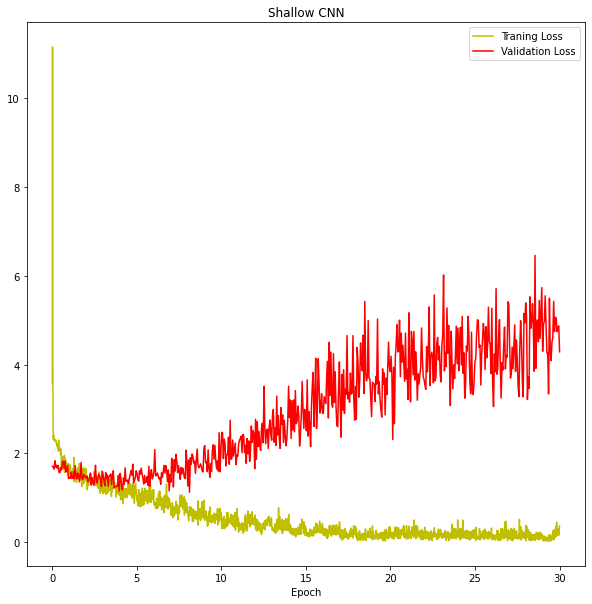

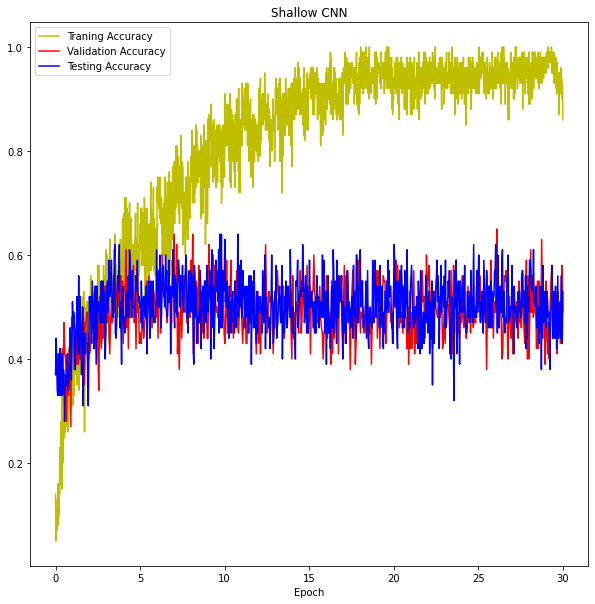

In [14]:
optim_valid_acc = 0
for epoch in range(n_epochs):
    print(epoch)

    #call the training function and pass training dataloader etc
    train_loss, train_acc, training_loss_logger,training_acc_logger= train(net, device, trainloader, optimizer, loss_fn, training_loss_logger,training_acc_logger)
    
    valid_loss, valid_acc, validation_loss_logger,validation_acc_logger = evaluate(net, device, valloader, loss_fn, validation_loss_logger,validation_acc_logger)

    #call the evaluate function and pass validation dataloader etc
    test_loss, test_acc, test_loss_logger,test_acc_logger = evaluate(net, device, testloader, loss_fn, test_loss_logger,test_acc_logger)

    #If this model has the highest performace on the validation set 
    #then save a checkpoint
    #{} define a dictionary, each entry of the dictionary is indexed with a string
    if (valid_acc > optim_valid_acc):
        print("Saving Model")
        best_model={
            'epoch':                 epoch,
            'model_state_dict':      net.state_dict(),
            'optimizer_state_dict':  optimizer.state_dict(), 
            'train_acc':             train_acc,
            'valid_acc':             valid_acc,
        }
    
    print(f'| Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:05.2f}% | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:05.2f}% |')


plt.figure(figsize=(10,10))
train_x = np.linspace(0, n_epochs, len(training_loss_logger))
plt.plot(train_x, training_loss_logger, c = "y")
valid_x = np.linspace(0, n_epochs, len(validation_loss_logger))
plt.plot(valid_x, validation_loss_logger, c = "r")

plt.title("Shallow CNN")
plt.legend(["Traning Loss", "Validation Loss"])
plt.xlabel("Epoch")

plt.figure(figsize = (10,10))
train_x = np.linspace(0, n_epochs, len(training_acc_logger))
plt.plot(train_x, (training_acc_logger), c = "y")
valid_x = np.linspace(0, n_epochs, len(validation_acc_logger))
plt.plot(valid_x, (validation_acc_logger), c = "r")
valid_x = np.linspace(0, n_epochs, len(test_acc_logger))
plt.plot(valid_x, (test_acc_logger), c = "b")


plt.title("Shallow CNN")
plt.legend(["Traning Accuracy", "Validation Accuracy","Testing Accuracy"])
plt.xlabel("Epoch")

In [15]:
## Testing

In [16]:
## Part IV, might need double check
## Test the matrix one by one
dataloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                          shuffle=True, num_workers=n_workers)

dev = torch.device('cpu')

max_array =[[],[],[],[],[],[],[],[],[],[]]
max_image_array=[[],[],[],[],[],[],[],[],[],[]]
rows = len(max_array)
columns = len(max_array[0])
min_array=np.copy(max_array)
min_image_array=np.copy(max_image_array)
confusion_matrix = [[0 for col in range(columns)] for row in range(rows)]
  
    
for i, (x, y) in enumerate(dataloader):
        image = x.to(device)
        output = net(image)
        pred = torch.argmax(output,dim=1,keepdim=True)
        ## Checking whether the classification == labels
        ## Indexed images array by the boolean and found the maximum score array 
        if (y.type(torch.LongTensor)==pred.to(dev)):
          p=pred.to(dev)[0][0].numpy()
          result=output[0][pred].to(dev)[0][0].detach().numpy()
          max_array[p].append(result)
          max_image_array[p].append(x)
          
          output=y.numpy()[0]
          confusion_mat[output][p]+=1
        
        else:
          
          p=pred.to(dev)[0][0].numpy()
          result=output[0][pred].to(dev)[0][0].detach().numpy()
          min_arr[p].append(result)
          min_image_array[p].append(x)
          
          result=y.numpy()[0]
          confusion_mat[result][p]+=1
        
print("Validation Set")          
print(np.matrix(confusion_matrix))

fig = plt.figure(figsize=(10,10))
#plt.xlabel("Initial randomized weights")
for index in range(rows):
  for j in range(5):
    index_matrix=np.where(max_arr[index] == np.amax(max_arr[index]))  
    ## Updating on the index for each row
    index_matrix=index_matrix[0][0]
    sub = fig.add_subplot(10,5,i*5+j+1)
    img=max_image_array[i][index_matrix].numpy()
    ## img.shape
    ## Updating
    img=img[0,:,:,:]
    img=np.moveaxis(img,0,2)
    sub.imshow(img/255.0)
    del max_arr[index][index_matrix]
    del max_img_arr[index][index_matrix]
    
fig = plt.figure(figsize=(10,10))
for index in range(rows):
  for j in range(5):
    index_matrix=np.where(min_array[index] == np.amax(min_array[index]))  
    ## Updating on the index for each row
    index_matrix=index_matrix[0][0]
    sub = fig.add_subplot(10,5,i*5+j+1)
    img=min_image_array[i][index_matrix].numpy()
    ## img.shape
    ## Updating
    img=img[0,:,:,:]
    img=np.moveaxis(img,0,2)
    sub.imshow(img/255.0)
    del min_array[index][index_matrix]
    del min_image_array[index][index_matrix]
    
    

72
72
72
72


RuntimeError: Boolean value of Tensor with more than one value is ambiguous